# Hypothesis test with LOB data using RDataFrame and RooFit

In this notebook, we will test the hypothesis that large bid orders placed deep in the order book can have an effect on the price development. This doesn't necessarily mean that there is a casual relation between the large order and the price change, but if it is really possible to influence the market with large limit orders deep in the order book, we would at least see that the price change after large orders behaves different compared to the price change after any order.

To test this hypothesis, we will look at the price change of the corn contract 10 seconds after a new bid order at depth 8 in the orderbook. In particular, we will compare the price change arfter such a bid order of any volume versus bid orders at depth 8 that are at least as large as 20 % of the existing volume in the order book.

### Introduction on statistical procedure for testing alternative hypothesis against null hypothesis

If you have a null hyposthesis and an alternative hypothesis for your model where you want to compare the compatibility the the data, the most powerful tests statistic is the likehood ratio:

$$\tilde{\lambda}(\mu) = \frac{L(\mu)}{L(0)}.$$

Note that the alternative hypothesis usually hase a parameter $\mu$ that we are interested in measuring.

If we have unknown model parameters that are not of interest but are still part of the model (nuisance parameters $\theta$}, these need to be optimized for each hypothesis before computing the likelihood ratio:

$$\tilde{\lambda}(\mu) = \frac{L(\mu,\hat{\hat{\theta}}(\mu))}{L(0,\hat{\hat{\theta}}(0))}.$$

This profiling "profiling" over the nuisance parameters means we take into account that we don't know their real values are are taking the most cautios route: we take their values to be the ones that give us the least discriminant likelihood ratio.

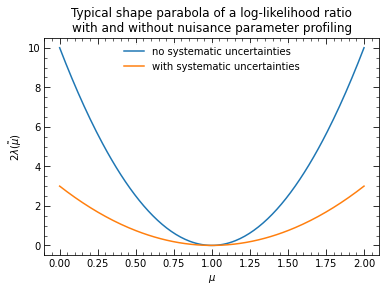

In [64]:
x = np.linspace(0, 2, 200)
plt.plot(x, 10*(x-1)**2, label="no systematic uncertainties")
plt.plot(x, 10*0.3*(x-1)**2, label="with systematic uncertainties")
plt.ylabel(r"$2\tilde{\lambda(\mu)}$")
plt.xlabel(r"$\mu$")
plt.legend()
plt.title("Typical shape parabola of a log-likelihood ratio\nwith and without nuisance parameter profiling")
plt.show()

In our example, the alternative hypothesis will have not parameter, e.g. $\mu$ is always a constant 1.

### Part 0 - Setup

In [ ]:
# Enter your CERN password to get access to the data files.
# You only need to run this once per SWAN session.

import getpass
import os
username = os.environ['USER']
if os.system('klist | grep Default | grep ' + username + '@CERN.CH'):
    os.system('echo %s' % getpass.getpass() + " | kinit " + username)

Do the usual imports of ROOT, numpy and matplotlib. Also import numba which we will use to quickly compute price changes in a given time window.

In [1]:
import numpy as np
import ROOT
from numba import jit
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.24/04


Import a helper function to add a numpy array as a column to an RDataFrame.

In [2]:
from rdf_utils import add_array_to_rdf

### Part 1 - Opening LOB data with RDataFrame and define new column with price change in time window

Opening the TTree with the LOB data

In [3]:
#filename = "20150504_20150508.root"
filename = "root://eosproject//eos/project/h/highlo/workshop/ZS_ZC/messages/20150504_20150508.root"
treename = "LOB"

tfile = ROOT.TFile.Open(filename)
tree = tfile.Get(treename)

Creating the RDF with the following filters and column definitions:
  * Filter messages for the most recent corn contract (`ZCN5` with `CInded == 1`)
  * Filter messages that are really actions
  * Define a flag that marks bid orders at depth 8
  * Define a flag that marks bid orders at depth 8 with a volume that is at least 20 % of the LOB volume at this side and depth

In [4]:
rdf = ROOT.RDataFrame(treename, tfile) \
        .Filter('ZCN5_IsOriginalMessage == true && ZCN5_CIndex == 1 && ActionIsAction == true') \
        .Define("IsNewLevel8BidOrder", "ActionSide == 0 && ActionType == 0 && ActionLevel == 8") \
        .Define("IsLargeNewLevel8BidOrder", "IsNewLevel8BidOrder && (1.0 * ActionVolume)/ZCN5_AskVolume8 > 0.2")

Define a numba function and a pure Python wrapper to compute the price chage in a given time window.

In [5]:
@jit(nopython=True)
def _fill_price_diff(time, price, diff, window):
    n = len(time)
    j = 0
    for i in range(n):
        while j + 1 < n and time[j + 1] - time[i] < window:
            j += 1
        diff[i] = price[j] - price[i]
        
def get_price_diff(time, price, window):
    diff = np.zeros(len(price), dtype=price.dtype)
    _fill_price_diff(time, price, diff, window)
    return diff

Calculate the price change withing a time window of 10 s after a given order and add this price change as a column to the data frame:

In [6]:
data = rdf.AsNumpy(["ZCN5_LastPrice", "Time"])
diff_rdf = get_price_diff(data["Time"], data["ZCN5_LastPrice"], window=10000 * 1000000)
rdf1 = add_array_to_rdf(rdf, "Diff", diff_rdf)

input_line_80:10:7: warning: ignoring return value of function declared with 'nodiscard' attribute [-Wunused-result]
      ((const vector<int>*)obj)->empty();
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
input_line_87:10:7: warning: ignoring return value of function declared with 'nodiscard' attribute [-Wunused-result]
      ((const vector<Long64_t>*)obj)->empty();
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
input_line_99:10:7: warning: ignoring return value of function declared with 'nodiscard' attribute [-Wunused-result]
      ((const vector<ULong64_t>*)obj)->empty();
      ^~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


### Part 2 - Plotting distribution of price changes

Now let's plot the distributions:
  * of price changes after all new bid orders at depth 8 (blue)
  * of price changes after all new bid orders at depth 8 where the volume exceeeds 20 % of existing volume at that level (red)

In [21]:
n_bins = 5
xlim = (-2.5, 2.5)
df_h_alt = rdf1.Filter("IsLargeNewLevel8BidOrder == true").Histo1D(
    ("IsLargeNewLevel8BidOrder", "New large level 8 bid orders;Price change in ticks within 10 s;Message",
     n_bins, *xlim), "Diff")
df_h_null = rdf1.Filter("IsNewLevel8BidOrder == true").Histo1D(
    ("IsNewLevel8BidOrder", "New level 8 bid orders;Price change in ticks within 10 s;Messages",
     n_bins, *xlim), "Diff")
h_alt = df_h_alt.GetValue()
h_null = df_h_null.GetValue()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


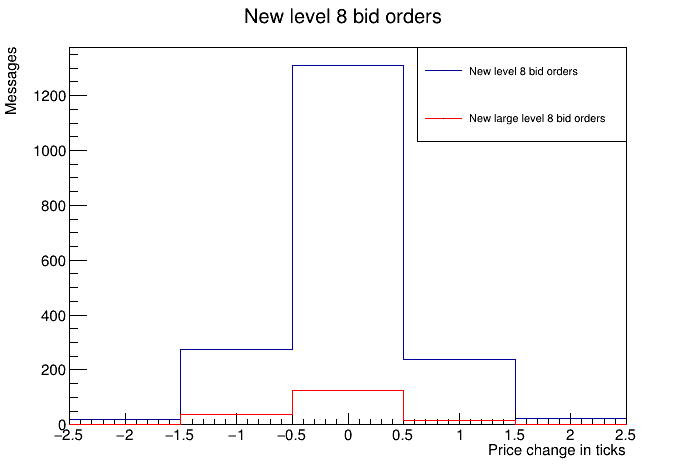

In [23]:
c1 = ROOT.TCanvas("c1")
h_alt.SetLineColor(ROOT.kBlue)
h_null.Draw()
h_alt.SetLineColor(ROOT.kRed)
h_alt.Draw("SAME")
ROOT.gStyle.SetOptStat(0)

legend = ROOT.TLegend(0.6,0.7,0.9,0.9)
legend.AddEntry(h_null)
legend.AddEntry(h_alt)
legend.Draw()

c1.Draw()

If it were possible to manipulate the market with large bid orders deep in the order book, the price change a given time after the message would be smaller for such large bid orders.

Looking at the listogram this could be the case: the red distribution is more asymetric than the blue one. But is this statistically significant? We can do a more rigurous statistical analysis with RooFit.

### Hypothesis testing with RooFit

The following statistical analysis might be a slight overkill for just comparing two histograms, but nevertheless it is an interesting example to demonstrate multiple RooFit features and give a feeling for what is possible.

Every part of the RooFit model is a ROOT objet, starting with the observable (in this case the price difference). We will also set the number of bins used for the observable:

In [9]:
x = ROOT.RooRealVar("x", "Price change in ticks within 10 s", 0.0, *xlim)
x.setBins(n_bins)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



Next we bring our histograms into RooFit land, connecting them to the observable `x`. The histograms have the suffices `_null` and `_alt` in the name, denoting our null hypothesis (distribution for all new bid orders at level 8) and the alternative hypotheis (distribution for large orders). We want to figure out whether the two distributions are compatible to check our hypothesis that large orders have a different effect on the price change.

In [10]:
roo_h_alt = ROOT.RooDataHist("roo_h_alt", "roo_h_alt", ROOT.RooArgList(x), ROOT.RooFit.Import(h_alt))
roo_h_null = ROOT.RooDataHist("roo_h_null", "roo_h_null", ROOT.RooArgList(x), ROOT.RooFit.Import(h_null))

Now we create template probability distributions that reflect the two histograms with the `RooHistPdf` class. Since these are pdfs, RooFit will take care of the normalization automatically now.

In [11]:
model_null = ROOT.RooHistPdf("model_null", "model_null", x, x, roo_h_null)
model_alt = ROOT.RooHistPdf("model_alt", "model_alt", x, x, roo_h_alt)

This is the **most tricky part** in this example: we will also consider the systematic uncertainty in our fit that arises from the statistical uncertaintles in the template histograms.

The problem is that if we only have a histogram that was sampled from an underlying distribution, we don't actually know the true distribution because the observed counts are distributed areound the unknown expected counts with a Poisson distribution.

To account for this, we add a new parameter for each bin in our null hythethisis model. These paramters are the ratios between the true expected values and the observed values in the template histograms. The `RooParamHistFunc` class wraps a simple `RooDataHist` and adds these scaling parameter for each bin. The `RooHistConstraint` object than adds the Poisson constraint to each of these new parameters. This pattern is inspired by the [rf709__BarlowBeeston_8py](https://root.cern/doc/master/rf709__BarlowBeeston_8py.html) tutorial.

These new parameters are **nuilsance parameters**: we are not really interested in their values, but we still need to find their optimal values given our observation to minimize the likelihood ratio. This is the likelihood profiling techinque to include systematic uncertainties in your fit.

Note that the `fitTo` call does not always work in the notebook, so this fit was precomputed and the result stored in a RooWorkspace. Like this, you can still run the remaining code in this notebook.

In [12]:
is_notebook = True
workspace_filename = "RooFit_HypothesisTest_LOB.root"

if not is_notebook:
    # construct the null hypothesis model with the nuisance parameters
    roo_h_null_param_func = ROOT.RooParamHistFunc("roo_h_null_param_func", "roo_h_null_param_func", roo_h_null)
    roo_h_null_param_constr = ROOT.RooHistConstraint("roo_h_null_param_constr",
                                                     "roo_h_null_param_constr",
                                                     roo_h_null_param_func)
    model_null_syst = ROOT.RooWrapperPdf("model_null_syst", "model_null_syst", roo_h_null_param_func)
    ROOT.RooProdPdf("tmp", "tmp",
                    ROOT.RooArgSet(roo_h_null_param_constr),
                    ROOT.RooFit.Conditional(model_null_syst, x)).fitTo(roo_h_alt)
        
    ws = ROOT.RooWorkspace("ws")
    ws.Import(model_null_syst)
    ws.writeToFile(workspace_filename)
else:
    wsfile = ROOT.TFile(workspace_filename)
    ws = wsfile.Get("ws")
    model_null_syst = ws.pdf("model_null_syst")

Let's visualize the price distribution for all orders and the large orders together:

[#0] ERROR:InputArguments -- RooTreeData::plotOn(roo_h_alt) ERROR: unrecognized command: Title
[#0] ERROR:InputArguments -- RooAbsReal::plotOn(model_null) ERROR: unrecognized command: Title


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TFile::Append>: Replacing existing TH1: dummy1 (Potential memory leak).
Warning in <TFile::Append>: Replacing existing TH1: dummy2 (Potential memory leak).


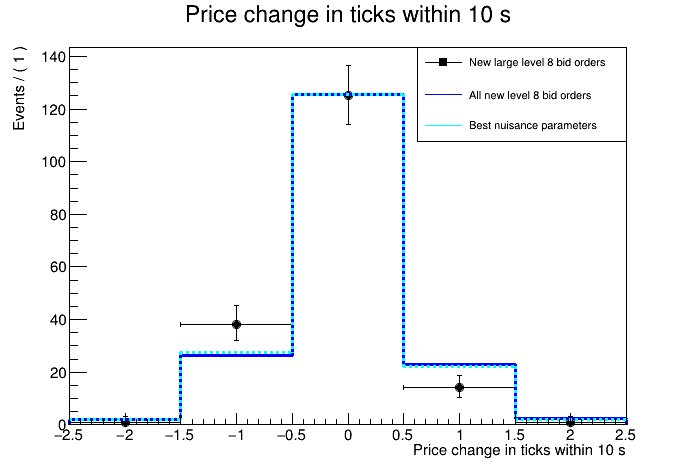

In [49]:
xframe = x.frame(ROOT.RooFit.Title(x.GetTitle()))

c1 = ROOT.TCanvas("c1")

roo_h_alt.plotOn(xframe, ROOT.RooFit.Title("Null hypothesis"))
model_null.plotOn(xframe, ROOT.RooFit.Title("Null hypothesis"))
model_null_syst.plotOn(xframe, ROOT.RooFit.LineColor(ROOT.kCyan), ROOT.RooFit.LineStyle(ROOT.kDashed))
xframe.Draw()


legend = ROOT.TLegend(0.6,0.7,0.9,0.9)
legend.AddEntry(roo_h_alt, "New large level 8 bid orders")
dummy1 = ROOT.TH1F("dummy1", "dummy1", 1, 0, 1)
dummy1.SetLineColor(ROOT.kBlue)
dummy2 = ROOT.TH1F("dummy2", "dummy2", 1, 0, 1)
dummy2.SetLineColor(ROOT.kCyan)
legend.AddEntry(dummy1, "All new level 8 bid orders", "l")
legend.AddEntry(dummy2, "Best nuisance parameters", "l")
legend.Draw()

c1.Draw()

Next we define a function for the statistical analysis we want to do:
  * compute the log-likelihood ratio for `n_toys` toy datasets generated according to the null hypothesis
  * visualize the test statistic distribution
  * compute log-likelihood ratio for histogram with large volume orders
  * check which fraction of the null hypothesis toys had a likelihood ratio even more incompatible with the null hypothesis to determine the p-value

In [14]:
def run_statistical_analysis(model_null, model_alt, data, n_toys=10000):
    
    n_data = int(data.sumEntries())
    
    q0 = np.zeros(n_toys)

    nll_null = None
    nll_alt = None

    for i_toy in range(n_toys):
        toy_data = model_null.generate(x, n_data).binnedClone()
        if nll_null is None:
            nll_null = model_null.createNLL(toy_data)
            nll_alt = model_alt.createNLL(toy_data)
        else:
            nll_null.setData(toy_data)
            nll_alt.setData(toy_data)
        q0[i_toy] = 2 * (nll_alt.getVal() - nll_null.getVal())

    plt.hist(q0, bins=int(n_toys**0.5))
    plt.ylabel("number of toys")
    plt.xlabel("2NLL ratio value")
    plt.title("2NLL ratio distribution determined with toys")
    plt.show()

    nll_null.setData(data)
    nll_alt.setData(data)
    q0_obs = 2 * (nll_alt.getVal() - nll_null.getVal())
    print("observed 2NLL ratio:", q0_obs)
    print("p-value:", (np.sum(q0 < q0_obs) / n_toys))

Run the statistical analysis with the initial null and alternative hypothesis:

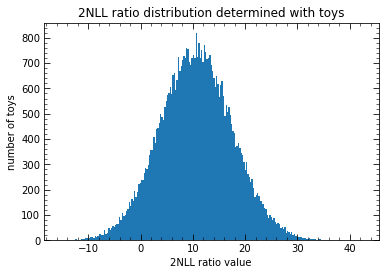

observed 2NLL ratio: -10.015796246638445
p-value: 0.00128


In [15]:
run_statistical_analysis(model_null, model_alt, roo_h_alt, n_toys=50000)

Finally run the analysis with the null model where the nuisance parameters of the null model were fit to the data histogram of large volume orders. The p-value should be larger now.

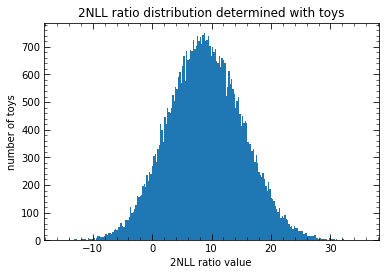

observed 2NLL ratio: -8.380841976087083
p-value: 0.00262
[#1] INFO:Minization -- createNLL: caching constraint set under name CONSTR_OF_PDF_model_null_syst_FOR_OBS_x with 0 entries


In [16]:
run_statistical_analysis(model_null_syst, model_alt, roo_h_alt, n_toys=50000)

Indeed the p-value is larger when we include the systematic uncertainty from the null hypothesis template, but the p-value is still small enough so we can conclude that large bid orders deep in the order book might have an effect on the price (or the other way around, unfortunately this analysis doesn't allow us to conclude on this).

### Conclusion and outlook

This notebook hopefully gave you an idea on what kind of likelihood analysis can be done with RooFit. In particular, it showed how to:
    * check two hypothesis (null hypothesis and alternative hypothesis) for compatibility using the likelihood ratio as a test statistic
    * convert histograms to template models in RooFit
    * how to consider the statistical uncertainties from these histograms as a systematic uncertainty in the hypothesis test
    
We used this hypothesis test to investigate whether large orders deep in the order book have an effect on price movement or vice versa.

If you want to learn more about the statistical methods used at the LHC, please take a look at the [Practical Statistics for the LHC](https://arxiv.org/pdf/1503.07622.pdf) guide. It also explains the asymptotic formulae you can use to avoid having to generate toys.